# Data Guided Sequential Search
Kyle Cranmer, June 2-15

##The Scenario

We imagine that we see an excess in some initial dataset, which we refer to as "run 1", and we want to know how to best use a subsequent "run 2" dataset for discovery. We are imagining that either:

 * several signal regions were defined in Run 1, some of which had a significant upward fluctuation, or 
 * after investigating an unexpected excess that the events can be subdivided into multiple (non-overlapping / disjoint) categories.
 
In both cases, the difficulty is that one does not have a signal model that allows one to relate the excess in the different categories or "bins". This leads to a few strategies:

 1. the inclusive strategy: merge the bins with a significant excess into one inclusive bin.
 1. the ideal strategy: one performs a combined likelihood fit with the correct signal model. This is not possible usually, but we use it for comparison.
 1. the nested strategy: where one starts with the bin with the highest significance excess and defines additional bins by merging with the bin with the next highest significance. This gives a nested set of selection regions. The problem here is that one has multiple tests and a look-elsewhere effect / trials factor to correct for, and the events are not statistically independent, so the analysis is tricky.
 1. the data guided sequential search strategy (DGSS): where one uses the excess in run 1 to define an emperical signal model to be used in run 2.
 
The basic idea of DGSS is that if the excess in run 1 is from the presence of signal and representative of the true signal, that it is a nearly optimal way to combine (ie. approximate the ideal strategy). While there are statisitcal fluctuations, the emperical signal model is not biased (ie. expectation = true signal) when there is no selection on run 1. When one only uses this procedure with a significant excess in run 1 it will introduce some bias on signal estimate. Thus we resort to some numerical simulations to check the power of this method in comparison to the ideal strategy and the inclusive strategy.

While it has not yet been formalized, we anticipate a recursive argument can be made in going from $N\to N+1$ bins. Therefore, we focus on the base of the recursion $1\to 2$ bins.


##The Model

We start with the model for run 1

\begin{equation}
Pois(n_1^1 | s_1 + b_1) Pois(n_2^1 | s_2 + b_2)
\end{equation}

From this run, we estimate $\hat{s}_i = n_i = b_i$ and then use those signal estimates in run 2, where the model is:
\begin{equation}
Pois(n_1^2 | \mu \hat{s}_1 + b_1) Pois(n_2^2 | \mu \hat{s}_2 + b_2)
\end{equation}

Based on run 2 we estimate the MLE $\hat{\mu}$, which is solved below using sympy.

Then, from the estimate of $\hat{\mu}$ we construct the liklelihood ratio test of the background only based on:

\begin{equation}
q_0 = -2 \ln \lambda(0) = -2 \ln \frac{L(\mu=0)}{L(\hat{\mu})}
\end{equation}

In [1]:
%pylab inline --no-import-all
from sympy import Symbol, symbols, solve, lambdify
#import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#plt.rc('text', usetex=True)
plt.rc('text', usetex=True)

In [3]:
#import matplotlib.pyplot as plt

In [4]:
#observables
(n11, n12, n21, n22) =  symbols('n11 n12 n21 n22')
#parameters
(s1, s2, b1, b2, mu) =  symbols('s1 s2 b1 b2 mu')
#helpers
(n1, n2, nu11, nu12, n21, nu22) =  symbols('n1 n2 nu11 nu12 nu21 n22')
#estimators
(s1hat, s2hat, muhat) = symbols('s1hat s2hat muhat')

In [5]:
#first run
nu11 = s1hat + b1
nu12 = s2hat + b2
#second run
nu21 = muhat*s1hat+b1
nu22 = muhat*s2hat+b2

In [6]:
#first run
shatSubs = [(key, val) for key,val in solve([n11-nu11, n12-nu12], s1hat, s2hat).iteritems()]
moreSubs = shatSubs+[(n11,10),(n12,10),(n21,10),(n22,10),(b1,5),(b2,5)]
s1hat.subs(moreSubs), s2hat.subs(moreSubs)

(5, 5)

In [7]:
#second run
[expr1, expr2] = solve( s1hat+s2hat - n21*s1hat/nu21 - n22*s2hat/nu22, muhat)

In [8]:
expr1.subs(moreSubs),expr2.subs(moreSubs)

(-1, 1)

In [9]:
muhatFunc = lambdify((n11,n12,n21,n22,b1,b2), expr2.subs(shatSubs), "numpy")
muhatFunc(10,10,10,10,5,5)

1.0

In [10]:
muhatFuncTruth = lambdify((n11,n12,n21,n22,b1,b2,s1hat,s2hat), expr2, "numpy")
muhatFuncTruth(10,10,10,10,5,5,5,5)

1.0

$Pois(n|\nu) = e^{-\nu} \nu^n/n!$

$-2 \log L(\nu) = 2*(\nu - n \ln \nu)$

$q(0) = -2 \log L(\nu)/L(\hat\nu) = 2*(\nu(0)-\hat{\nu}) - n \ln \nu(0) / \hat\nu )$

In [11]:
def inclusive_muhatFunc(n11,n12,n21,n22,b1,b2):
    shat = 1.*(n11+n12-b1-b2)+.01
    return np.maximum(-7,np.minimum(7,np.divide(n21+n22-b1-b2,shat)))

In [12]:
def q0inclusive(n11,n12,n21,n22,b1,b2):
    #shat = 1.*(n11+n12-b1-b2)+.01
    #muhat = np.divide(n21+n22-b1-b2,shat)
    return 2*(-(n21+n22-b1-b2) - (n21+n22)*np.log((b1+b2)/(n21+n22)))

In [13]:
def q0DGSS(n11,n12,n21,n22,b1,b2):
    muhat = muhatFunc(n11,n12,n21,n22,b1,b2)
    s1hat = 1.*(n11-b1)
    s2hat = 1.*(n12-b2)
    q_1 = 2*( -muhat*s1hat - (n21)*np.log((b1)/(b1+s1hat*muhat)))
    q_2 = 2*( -muhat*s2hat - (n22)*np.log((b2)/(b2+s2hat*muhat)))
    return q_1+q_2

In [14]:
def q0Truth(n11,n12,n21,n22,b1,b2,s1hat,s2hat):
    muhat = muhatFuncTruth(n11,n12,n21,n22,b1,b2,s1hat,s2hat)
    #s1hat = s1
    #s2hat = s2
    q_1 = 2*( -muhat*s1hat - (n21)*np.log((b1)/(b1+s1hat*muhat)))
    q_2 = 2*( -muhat*s2hat - (n22)*np.log((b2)/(b2+s2hat*muhat)))
    return q_1+q_2

## Generate toy experiments *with*  Run-1 filtering

In [53]:
#b experiments, with filtering
nExp = 3000000
btruth=[(b1,100),(b2,100)]
struth=[(s1hat,0),(s2hat,0),(muhat,0)]
truth=btruth+struth
n11_expts = np.random.poisson(nu11.subs(truth),nExp)
n12_expts = np.random.poisson(nu12.subs(truth),nExp)
#n21_expts = np.random.poisson(nu21.subs(truth),nExp)
#n22_expts = np.random.poisson(nu22.subs(truth),nExp)
temp = np.zeros(nExp*2).reshape(nExp,2)
temp[:,0] = n11_expts
temp[:,1] = n12_expts
#temp[:,2] = n21_expts
#temp[:,3] = n22_expts
temp = np.array(filter(lambda x: x[0]>b1.subs(truth)*1.1 and x[1]>b2.subs(truth)*1.1, temp))
n11_expts = temp[:,0]
n12_expts = temp[:,1]
#n21_expts = temp[:,2]
#n22_expts = temp[:,3]
n21_expts = np.random.poisson(nu21.subs(truth),n11_expts.size)
n22_expts = np.random.poisson(nu22.subs(truth),n11_expts.size)
muhat_b_expts = muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
muhat_b_expts = filter(lambda x: x<1e6, muhat_b_expts)
muhat_b_expts =  np.maximum(-10,np.minimum(10,muhat_b_expts))
inclusive_muhat_b_expts = inclusive_muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
inclusive_q0_b_expts = q0inclusive(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
q0_b_expts = q0DGSS(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
nu11.subs(truth),nu12.subs(truth),nu21.subs(truth),nu22.subs(truth)
print len(n22_expts), 'b experiments'

64493 b experiments


In [54]:
#b truth experiments, need to know true signal rate
#experiments are still the b-only ones
struth=[(s1hat,50),(s2hat,1),(muhat,1)]
truth=btruth+struth
truth_q0_b_expts = q0Truth(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)),float(s1hat.subs(truth)),float(s2hat.subs(truth)))

In [55]:
np.max(truth_q0_b_expts)

21.629604480626714

In [65]:
#s experiments, with filtering
nExp = 400000
#ok, now make s+b experimentes
n11_expts = np.random.poisson(nu11.subs(truth),nExp)
n12_expts = np.random.poisson(nu12.subs(truth),nExp)
#n21_expts = np.random.poisson(nu21.subs(truth),nExp)
#n22_expts = np.random.poisson(nu22.subs(truth),nExp)
temp = np.zeros(nExp*2).reshape(nExp,2)
temp[:,0] = n11_expts
temp[:,1] = n12_expts
#temp[:,2] = n21_expts
#temp[:,3] = n22_expts
temp = np.array(filter(lambda x: x[0]>b1.subs(truth)*1.1 and x[1]>b2.subs(truth)*1.1, temp))
n11_expts = temp[:,0]
n12_expts = temp[:,1]
#n21_expts = temp[:,2]
#n22_expts = temp[:,3]
n21_expts = np.random.poisson(nu21.subs(truth),n11_expts.size)
n22_expts = np.random.poisson(nu22.subs(truth),n11_expts.size)
muhat_s_expts = muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
muhat_s_expts = filter(lambda x: x<1e6, muhat_s_expts)
muhat_s_expts =  np.maximum(-10,np.minimum(10,muhat_s_expts))
inclusive_muhat_s_expts = inclusive_muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
inclusive_q0_s_expts = q0inclusive(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
q0_s_expts = q0DGSS(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
truth_q0_s_expts = q0Truth(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)),float(s1hat.subs(truth)),float(s2hat.subs(truth)))
nu11.subs(truth),nu12.subs(truth),nu21.subs(truth),nu22.subs(truth)
len(muhat_s_expts)

68538

## Plots for the signal strength estimate

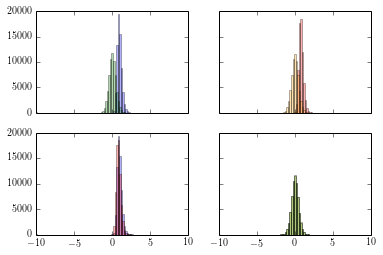

In [66]:
#figsize(600,600)
edges = np.linspace(-10,10,100)
fig, ax = plt.subplots(2,2,sharex=True, sharey=True)
#plt.figure(None,figsize=(1800,1800))

# DGSS s+b vs. b experiments
contents, edges, patches = ax[0][0].hist(muhat_s_expts,bins=edges,alpha=0.3,color='b')
contents, edges, patches = ax[0][0].hist(muhat_b_expts,bins=edges,alpha=0.3,color='g')

# inclusive s+b vs. b experiments
contents, edges, patches = ax[0][1].hist(inclusive_muhat_s_expts,bins=edges,alpha=0.3,color='r')
contents, edges, patches = ax[0][1].hist(inclusive_muhat_b_expts,bins=edges,alpha=0.3,color='orange')

# comparison for s+b experiments
contents, edges, patches = ax[1][0].hist(muhat_s_expts,bins=edges,alpha=0.3,color='b')
contents, edges, patches = ax[1][0].hist(inclusive_muhat_s_expts,bins=edges,alpha=0.3,color='r')

# comparison for b experiments
contents, edges, patches = ax[1][1].hist(inclusive_muhat_b_expts,bins=edges,alpha=0.3,color='orange')
contents, edges, patches = ax[1][1].hist(muhat_b_expts,bins=edges,alpha=0.3,color='g')

Notes to self:

current filtering is s1hat >0 and s2hat > 0. Instead we might want cumulative n1+n2-b1-b2>0, but then need to make this method ignore bin if sihat<0.

Might want to cut harder than 0

muhat not best test statistic. If shat small and n2-b2 also small, can get muhat large. Should move to lambda(0).


## plots of the q_0 test statistic for inclusive, ideal, and DGSS

In [67]:
testSize=0.001

13.0199453786 0.205169274628


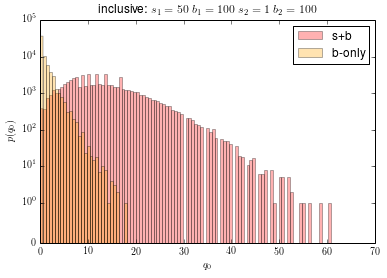

In [68]:
pylab.yscale('symlog',linthreshy=1) #works for histograms
i_s_contents, edges, patches = plt.hist(inclusive_q0_s_expts,normed=False, bins=100, alpha=0.3, color='r')
i_b_contents, edges, patches = plt.hist(inclusive_q0_b_expts,normed=False, bins=edges, alpha=0.3, color='orange')
i_s_cumsum = np.cumsum(i_s_contents)/np.sum(i_s_contents)
i_b_cumsum = np.cumsum(i_b_contents)/np.sum(i_b_contents)
i_index = np.searchsorted(i_b_cumsum,1.-testSize)
print np.mean(inclusive_q0_s_expts), np.var(inclusive_q0_s_expts)/np.sqrt(inclusive_q0_s_expts.size)
plt.xlabel('$q_0$')
plt.ylabel('$p( q_0 )$')
plt.legend(('s+b', 'b-only'),loc='upper right')
plt.title('inclusive: $s_1=%d$ $b_1=%d$ $s_2=%d$ $b_2=%d$' %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))
#plt.ylim(1e-4,1)
plt.savefig("q0_dist_incl_s1_%d_b1_%d_s2_%d_b2_%d.pdf" %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))

20.444914618 0.348139477587


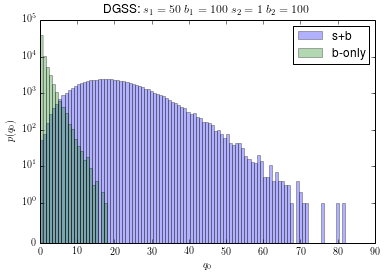

In [69]:
pylab.yscale('symlog',linthreshy=1) #works for histograms
s_contents, edges, patches = plt.hist(q0_s_expts, bins=100, alpha=0.3, color='b')
b_contents, edges, patches = plt.hist(q0_b_expts, bins=edges, alpha=0.3, color='g')
s_cumsum = np.cumsum(s_contents)/np.sum(s_contents)
b_cumsum = np.cumsum(b_contents)/np.sum(b_contents)
index = np.searchsorted(b_cumsum,1.-testSize)
print np.mean(q0_s_expts), np.var(q0_s_expts)/np.sqrt(q0_s_expts.size)
plt.xlabel('$q_0$')
plt.ylabel('$p( q_0 )$')
plt.legend(('s+b', 'b-only'),loc='upper right')
plt.title('DGSS: $s_1=%d$ $b_1=%d$ $s_2=%d$ $b_2=%d$' %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))
plt.savefig("q0_dist_DGSS_s1_%d_b1_%d_s2_%d_b2_%d.pdf" %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))

22.629480736 0.381990228924


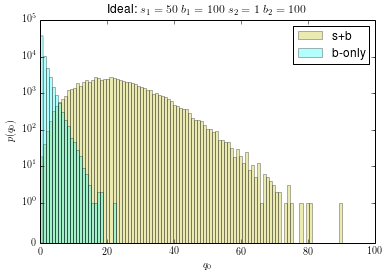

In [70]:
pylab.yscale('symlog',linthreshy=1) #works for histograms
truth_s_contents, edges, patches = plt.hist(truth_q0_s_expts, bins=100, alpha=0.3, color='y')
truth_b_contents, edges, patches = plt.hist(truth_q0_b_expts, bins=edges, alpha=0.3, color='cyan')
truth_s_cumsum = np.cumsum(truth_s_contents)/np.sum(truth_s_contents)
truth_b_cumsum = np.cumsum(truth_b_contents)/np.sum(truth_b_contents)
truth_index = np.searchsorted(truth_b_cumsum,1.-testSize)
print np.mean(truth_q0_s_expts), np.var(truth_q0_s_expts)/np.sqrt(truth_q0_s_expts.size)
plt.xlabel('$q_0$')
plt.ylabel('$p( q_0 )$')
plt.legend(('s+b', 'b-only','other'),loc='upper right')
plt.title('Ideal: $s_1=%d$ $b_1=%d$ $s_2=%d$ $b_2=%d$' %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))
plt.savefig("tq0_dist_truth_s1_%d_b1_%d_s2_%d_b2_%d.pdf" %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))

In [71]:
i_index, index, truth_index

(18, 13, 12)

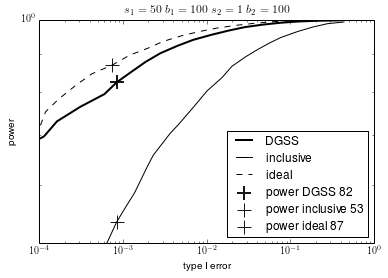

In [72]:
plt.plot(1.-b_cumsum,1.-s_cumsum,c='black',lw=2)
plt.plot(1.-i_b_cumsum,1.-i_s_cumsum,c='black',lw=1)
plt.plot(1.-truth_b_cumsum,1.-truth_s_cumsum,c='black',lw=1,ls='--')
plt.scatter(1.-b_cumsum[index],1.-s_cumsum[index],alpha=0.9,marker='+',s=200,lw=2, c='black')
plt.scatter(1.-i_b_cumsum[i_index],1.-i_s_cumsum[i_index],alpha=0.9,marker='+',s=200,c='black')
plt.scatter(1.-truth_b_cumsum[truth_index],1.-truth_s_cumsum[truth_index],alpha=0.9,marker='+',s=200,c='black')
power_DGSS=100*(1.-s_cumsum[index])
power_inclusive=100*(1.-i_s_cumsum[i_index])
power_truth=100*(1.-truth_s_cumsum[truth_index])
lab_power_DGSS='power DGSS %.0f %%' %(power_DGSS)
lab_power_inclusive='power inclusive %.0f%%' %(power_inclusive)
lab_power_truth='power ideal %.0f %%' %(power_truth)
plt.xlabel('type I error')
plt.ylabel('power')
plt.title('$s_1=%d$ $b_1=%d$ $s_2=%d$ $b_2=%d$' %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))
plt.legend(('DGSS', 'inclusive','ideal',lab_power_DGSS,lab_power_inclusive,lab_power_truth),loc='lower right', scatterpoints=1 )
plt.ylim(5e-1,1)
plt.xlim(1e-4,1)
plt.loglog()
plt.savefig("q0_power_s1_%d_b1_%d_s2_%d_b2_%d.pdf" %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))

(1.4590446175799521e-05, 1.05)

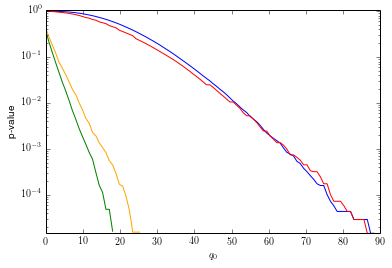

In [73]:
plt.plot(edges[:-1],1.-s_cumsum,c='b')
plt.plot(edges[:-1],1.-b_cumsum,c='g')
plt.plot(edges[:-1],1.-i_s_cumsum,c='r')
plt.plot(edges[:-1],1.-i_b_cumsum,c='orange')
plt.xlabel('$q_0$')
plt.ylabel('p-value')
plt.semilogy()
plt.ylim(0,1.05)

## Notes:

For bi=100, s1=25, s2=0, the b-only q0 distributions aren't the same, one of them isn't a chi^2. Probably DGSS distribution - numerator is invariant, but denominator of both depends on shat... but seems like inclusive approach probaby just soem rescailing while DGSS depends on n11/n12.  Didn't see that for s1=50, why would b-only depend?

In [30]:
#np.searchsorted?

In [ ]:
#plt.legend?